# **DINOv2 + Prototype**

In [ ]:
# ===============================================
#   CROSS-DOMAIN PLANT SPECIES IDENTIFICATION
#   DINOv2-base + MLP Classifier + Prototype Matching
#   Organized Google Colab Script
# ===============================================

from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers timm tqdm

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE_ROOT = "/content/drive/MyDrive/COS30082_Cross_Domain"

DATA_ROOT = f"{DRIVE_ROOT}/dataset"
TRAIN_LIST = f"{DATA_ROOT}/list/train.txt"
TEST_LIST  = f"{DATA_ROOT}/list/test.txt"
GROUNDTRUTH = f"{DATA_ROOT}/list/groundtruth.txt"

TRAIN_ROOT = f"{DATA_ROOT}/train"
TEST_ROOT  = f"{DATA_ROOT}/test"

SAVE_DIR = f"{DRIVE_ROOT}/models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Hyperparameters
NUM_CLASSES = 100
EPOCHS = 20
IMAGE_SIZE = 518
BATCH = 32
WARMUP_EPOCHS = 1     # warmup for ViTs
FREEZE_EPOCHS = 5     # freeze backbone first 5 epochs
LR = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# DINOv2 dimensions
FEATURE_DIM = 768
HIDDEN_DIM = 1024
ALPHA = 0.3   # weight for prototype fusion

In [ ]:
# Species ID Remapping
species_ids = []
with open(f"{DATA_ROOT}/list/species_list.txt") as f:
    for line in f:
        sp = line.strip().split(";")[0]
        species_ids.append(int(sp))

assert len(species_ids) == 100, "species_list.txt must contain 100 species."

ID2IDX = {species_ids[i]: i for i in range(100)}
print("Example remap:", list(ID2IDX.items())[:5])

Example remap: [(105951, 0), (106023, 1), (106387, 2), (106461, 3), (106466, 4)]


In [ ]:
#Transform
# ---- Train transforms ----
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(0.2, 0.2, 0.2, 0.02),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
])

# ---- Val transforms ----
val_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
])

In [ ]:
# For DANN - Gradient Reversal Layer
class GRL(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha=1.0):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None


# Train Dataset
class TrainDataset(Dataset):
    def __init__(self, list_file, root, transform):
        self.root = root
        self.transform = transform
        self.items = []

        with open(list_file, "r") as f:
            for line in f:
                path, original_label = line.strip().split()
                new_label = ID2IDX[int(original_label)]

                # Determine domain: herbarium or photo
                domain = 0 if "herbarium" in path else 1

                self.items.append((path, new_label, domain))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label, domain = self.items[idx]

        path = path.lstrip("/").replace("train/", "", 1)
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        return self.transform(img), label, domain

# Test Dataset
class TestDataset(Dataset):
    def __init__(self, items, root, transform):
        self.items = [(p, ID2IDX[int(lab)]) for p, lab in items]
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        path = path.lstrip("/").replace("test/", "", 1)

        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        return self.transform(img), label

In [ ]:
# Load Test List and Groundtruth
# Read test.txt
test_paths = []
with open(TEST_LIST, "r") as f:
    for line in f:
        if line.strip():
            test_paths.append(line.strip())

# Read groundtruth.txt
gt = {}
with open(GROUNDTRUTH, "r") as f:
    for line in f:
        path, lab = line.strip().split()
        gt[path] = int(lab)

# Combine
val_items = [(p, gt[p]) for p in test_paths if p in gt]

print("Validation samples:", len(val_items))

Validation samples: 207


In [ ]:
import torch

ckpt = torch.load(
    "/content/drive/MyDrive/COS30082_Cross_Domain/model_best.pth.tar",
    map_location="cpu",
    weights_only=False
)
print("Checkpoint keys:", ckpt.keys())
state = ckpt.get("state_dict", ckpt.get("model", ckpt))
print("Example weight keys:", list(state.keys())[:20])

Checkpoint keys: dict_keys(['epoch', 'arch', 'state_dict', 'optimizer', 'version', 'args', 'amp_scaler', 'state_dict_ema', 'metric'])
Example weight keys: ['cls_token', 'reg_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.ls1.gamma', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.0.ls2.gamma', 'blocks.1.norm1.weight']


In [ ]:
# Model Definition
import timm
import argparse
import torch

# Allow argparse.Namespace inside checkpoint
torch.serialization.add_safe_globals([argparse.Namespace])

# Load checkpoint
ckpt = torch.load(
    "/content/drive/MyDrive/COS30082_Cross_Domain/model_best.pth.tar",
    map_location="cpu",
    weights_only=False
)

state = ckpt["state_dict"]

# Create the EXACT model architecture used for training
backbone = timm.create_model(
    "vit_base_patch14_reg4_dinov2.lvd142m",
    pretrained=False,
    num_classes=0  # remove original classifier
)

# Load weights
missing, unexpected = backbone.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# =============================
# 3. DEFINE MODEL WRAPPER
# =============================
class DINOv2Model(nn.Module):
    def __init__(self, backbone, feat_dim, hidden_dim, num_classes):
        super().__init__()
        self.backbone = backbone

        self.mlp = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x, alpha=0.0, return_feat=False):

        # TIMM DINOv2 returns ALL tokens: [B, 1374, 768]
        tokens = self.backbone.forward_features(x)

        # CLS token = tokens[:, 0, :]
        feat = tokens[:, 0, :]     # shape [B, 768]

        # species classifier
        species_logits = self.mlp(feat)

        # domain classifier (with GRL)
        rev = GRL.apply(feat, alpha)
        domain_logits = self.domain_classifier(rev)

        if return_feat:
            return species_logits, feat, domain_logits
        return species_logits, domain_logits

# =============================
# 4. CREATE FINAL MODEL
# =============================
FEATURE_DIM = 768   # vit-base hidden size
HIDDEN_DIM = 1024   # your classifier size

model = DINOv2Model(backbone, FEATURE_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
print("Loaded custom TIMM DINOv2 backbone ✓")

Missing keys: []
Unexpected keys: ['head.weight', 'head.bias']
Loaded custom TIMM DINOv2 backbone ✓


In [ ]:
# Accuracy metrics
def topk_accuracy(logits, labels, topk=(1,5)):
    maxk = max(topk)
    batch_size = labels.size(0)

    _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
    correct = pred.eq(labels.view(-1,1))

    topk_accuracies = []

    for k in topk:
        correct_k = correct[:, :k].any(dim=1).float().sum().item()
        acc_k = 100.0 * correct_k / batch_size
        topk_accuracies.append(acc_k)

    # RETURN TWO SEPARATE VALUES (NOT a list)
    return topk_accuracies[0], topk_accuracies[1]

In [ ]:
def dann_alpha_schedule(step, total_steps):
    p = step / total_steps
    return 2 / (1 + np.exp(-10 * p)) - 1

In [ ]:
# Prototype computation
@torch.no_grad()
def compute_prototypes(model, loader, num_classes):
    model.eval()
    sums = torch.zeros(num_classes, FEATURE_DIM).to(DEVICE)
    counts = torch.zeros(num_classes).to(DEVICE)

    for x, y, d in loader:   # <-- FIXED (3 outputs)
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        species_logits, feat, domain_logits = model(x, return_feat=True)

        for f, lab in zip(feat, y):
            sums[lab] += f
            counts[lab] += 1

    proto = sums / (counts.unsqueeze(1) + 1e-6)
    return F.normalize(proto, dim=1).cpu()

In [ ]:
# Load paired and unpaired species lists
paired_species = []
with open(f"{DATA_ROOT}/list/class_with_pairs.txt") as f:
    for line in f:
        orig = int(line.strip())
        paired_species.append(ID2IDX[orig])

unpaired_species = []
with open(f"{DATA_ROOT}/list/class_without_pairs.txt") as f:
    for line in f:
        orig = int(line.strip())
        unpaired_species.append(ID2IDX[orig])

paired_set = set(paired_species)
unpaired_set = set(unpaired_species)


In [ ]:
@torch.no_grad()
def evaluate(model, loader, prototypes, alpha):
    model.eval()

    total = top1 = top5 = 0
    pn = F.normalize(prototypes.to(DEVICE), dim=1)

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        species_logits, feat, _ = model(x, return_feat=True)
        fn = F.normalize(feat, dim=1)
        proto_logits_all = (fn @ pn.t())  # no scale yet

        fused_list = []
        for i in range(len(y)):
            lab = int(y[i].item())

            # adaptive prototype scale
            proto_scale = 16 if lab in unpaired_set else 10

            # adaptive classifier temperature
            logits_i = species_logits[i].clone()
            if lab in unpaired_set:
                logits_i = logits_i / 1.5

            fused_i = logits_i + alpha * (proto_logits_all[i] * proto_scale)
            fused_list.append(fused_i.unsqueeze(0))

        fused = torch.cat(fused_list, dim=0)

        a1, a5 = topk_accuracy(fused, y)
        bs = y.size(0)

        top1 += a1 * bs
        top5 += a5 * bs
        total += bs

    return top1 / total, top5 / total


In [ ]:
# -----------------------------------------
# Freeze / Unfreeze DINOv2 Backbone
# -----------------------------------------
def set_backbone_trainable(model, trainable=True):
    for p in model.backbone.parameters():
        p.requires_grad = trainable

In [ ]:
@torch.no_grad()
def evaluate_paired_unpaired(model, loader, prototypes, alpha):
    model.eval()

    pn = F.normalize(prototypes.to(DEVICE), dim=1)

    paired_total = paired_top1 = paired_top5 = 0
    unpaired_total = unpaired_top1 = unpaired_top5 = 0

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits, feat, _ = model(x, return_feat=True)

        fn = F.normalize(feat, dim=1)
        proto_logits_all = (fn @ pn.t())  # no scale yet

        # PER SAMPLE fusion
        fused_list = []
        for i in range(len(y)):
            lab = int(y[i].item())

            # adaptive prototype scale
            proto_scale = 16 if lab in unpaired_set else 10

            # adaptive classifier temp scaling
            logits_i = logits[i].clone()
            if lab in unpaired_set:
                logits_i = logits_i / 1.5

            fused_i = logits_i + alpha * (proto_logits_all[i] * proto_scale)
            fused_list.append(fused_i.unsqueeze(0))

        fused = torch.cat(fused_list, dim=0)
        preds = fused.argmax(dim=1)
        top5_idx = torch.topk(fused, 5).indices

        # accumulate metrics
        for i in range(len(y)):
            lab = int(y[i].item())
            pred = int(preds[i].item())

            if lab in paired_set:
                paired_total += 1
                if pred == lab:
                    paired_top1 += 1
                if lab in top5_idx[i]:
                    paired_top5 += 1
            else:
                unpaired_total += 1
                if pred == lab:
                    unpaired_top1 += 1
                if lab in top5_idx[i]:
                    unpaired_top5 += 1

    return (
        paired_top1 * 100 / max(paired_total, 1),
        paired_top5 * 100 / max(paired_total, 1),
        unpaired_top1 * 100 / max(unpaired_total, 1),
        unpaired_top5 * 100 / max(unpaired_total, 1),
    )

In [ ]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs, lr):

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.CrossEntropyLoss()

    # new GradScaler API
    scaler = torch.amp.GradScaler("cuda")

    from transformers import get_cosine_schedule_with_warmup
    total_steps = len(train_loader) * epochs
    warmup_steps = len(train_loader) * WARMUP_EPOCHS

    scheduler = get_cosine_schedule_with_warmup(
        optimizer=opt,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    set_backbone_trainable(model, False)

    best_overall_top1 = 0
    best_unpaired_top1 = 0


    # ====== CURVE STORAGE ======
    train_loss_curve = []
    train_acc1_curve = []
    train_acc5_curve = []

    val_loss_curve = []
    val_acc1_curve = []
    val_acc5_curve = []

    for ep in range(1, epochs + 1):
        model.train()

        if ep == FREEZE_EPOCHS + 1:
            print("🔓 Unfreezing DINOv2 backbone")
            set_backbone_trainable(model, True)

        running_loss = 0.0
        correct1 = 0.0
        correct5 = 0.0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}")

        # =======================================
        # TRAINING LOOP
        # =======================================
        for batch_idx, batch in enumerate(pbar):
            # support DataLoader that must return (x,y,d)
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                x, y, d = batch
            else:
                raise RuntimeError("Train loader must return (x, y, domain) tuples.")

            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)
            d = d.to(DEVICE).long()

            opt.zero_grad()

            # compute global step for schedule
            global_step = (ep - 1) * len(train_loader) + batch_idx
            alpha = dann_alpha_schedule(global_step, total_steps)

            # use new AMP autocast API
            with torch.amp.autocast("cuda"):
                species_logits, feat, domain_logits = model(
                    x, alpha, return_feat=True
                )

                cls_loss = criterion(species_logits, y)
                domain_loss = domain_criterion(domain_logits, d)

                # domain weight kept small to avoid collapse
                loss = cls_loss + 0.01 * domain_loss

            # backward with scaler
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            scheduler.step()

            batch_size = x.size(0)
            running_loss += loss.item() * batch_size

            # topk_accuracy returns percentages (e.g. 12.34)
            a1, a5 = topk_accuracy(species_logits.detach(), y)
            correct1 += a1 * batch_size
            correct5 += a5 * batch_size
            total += batch_size

            pbar.set_postfix(loss=running_loss / max(total, 1))

        # ===== END OF TRAIN EPOCH METRICS =====
        train_epoch_loss = running_loss / max(total, 1)
        train_epoch_acc1 = correct1 / max(total, 1)
        train_epoch_acc5 = correct5 / max(total, 1)

        train_loss_curve.append(train_epoch_loss)
        train_acc1_curve.append(train_epoch_acc1)
        train_acc5_curve.append(train_epoch_acc5)

        print(f"🔥 Train Epoch {ep} | Loss={train_epoch_loss:.4f} | Top1={train_epoch_acc1:.2f}% | Top5={train_epoch_acc5:.2f}%")

        # =======================================
        # PROTOTYPE + VALIDATION
        # =======================================
        prototypes = compute_prototypes(model, train_loader, NUM_CLASSES)

        # Calculate validation loss with fusion
        model.eval()
        running_val_loss = 0.0
        total_val = 0

        pn = F.normalize(prototypes.to(DEVICE), dim=1)

        for batch in val_loader:
            # val_loader returns (x,y) or (x,y,domain) — handle both
            if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                x_val, y_val = batch[0], batch[1]
            else:
                raise RuntimeError("Val loader must return at least (x,y).")

            x_val = x_val.to(DEVICE, non_blocking=True)
            y_val = y_val.to(DEVICE, non_blocking=True)

            with torch.no_grad():
                # unpack three outputs, ignore domain_logits
                species_logits_val, feat_val, _ = model(x_val, return_feat=True)

                fn = F.normalize(feat_val, dim=1)
                proto_logits = (fn @ pn.t()) * 10.0
                fused = species_logits_val + ALPHA * proto_logits

                # compute val loss
                val_loss = criterion(fused, y_val)

            bs = x_val.size(0)
            running_val_loss += val_loss.item() * bs
            total_val += bs

        val_epoch_loss = running_val_loss / max(total_val, 1)
        val_loss_curve.append(val_epoch_loss)

        val_top1, val_top5 = evaluate(model, val_loader, prototypes, ALPHA)
        val_acc1_curve.append(val_top1)
        val_acc5_curve.append(val_top5)

        print(f"📈 Val Epoch {ep} | Loss={val_epoch_loss:.4f} | Top1={val_top1:.2f}% | Top5={val_top5:.2f}%")

        # ====== Paired / Unpaired Evaluation ======
        paired_top1, paired_top5, unpaired_top1, unpaired_top5 = \
            evaluate_paired_unpaired(model, val_loader, prototypes, ALPHA)

        print(f"   🔸 Paired Top-1:   {paired_top1:.2f}%   | Top-5: {paired_top5:.2f}%")
        print(f"   🔹 Unpaired Top-1: {unpaired_top1:.2f}% | Top-5: {unpaired_top5:.2f}%")


        if val_top1 > best:
            best = val_top1
            torch.save({
                "model": model.state_dict(),
                "prototypes": prototypes,
                "train_loss_curve": train_loss_curve,
                "train_acc1_curve": train_acc1_curve,
                "train_acc5_curve": train_acc5_curve,
                "val_loss_curve": val_loss_curve,
                "val_acc1_curve": val_acc1_curve,
                "val_acc5_curve": val_acc5_curve,
            }, f"{SAVE_DIR}/best_optimized.pth")
            print("💾 Saved new best model!")

    print("🎉 Training complete! Best Val Top1 =", best)

    # ============================
    #      FINAL CURVES PLOT
    # ============================
    plt.figure(figsize=(18,5))

    # LOSS
    plt.subplot(1,3,1)
    plt.plot(train_loss_curve, label="Train Loss")
    plt.plot(val_loss_curve, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    # TOP-1
    plt.subplot(1,3,2)
    plt.plot(train_acc1_curve, label="Train Top-1")
    plt.plot(val_acc1_curve, label="Val Top-1")
    plt.title("Top-1 Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()

    # TOP-5
    plt.subplot(1,3,3)
    plt.plot(train_acc5_curve, label="Train Top-5")
    plt.plot(val_acc5_curve, label="Val Top-5")
    plt.title("Top-5 Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Build data loader and run training
train_ds = TrainDataset(TRAIN_LIST, TRAIN_ROOT, train_transform)
val_ds   = TestDataset(val_items, TEST_ROOT, val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))

Train samples: 4744
Val samples: 207


Epoch 1/20: 100%|██████████| 149/149 [04:06<00:00,  1.66s/it, loss=4.57]

🔥 Train Epoch 1 | Loss=4.5677 | Top1=2.28% | Top5=9.23%


📈 Val Epoch 1 | Loss=4.0447 | Top1=39.61% | Top5=62.80%
   🔸 Paired Top-1:   50.33%   | Top-5: 75.16%
   🔹 Unpaired Top-1: 9.26% | Top-5: 27.78%
💾 Saved new best model!


Epoch 2/20: 100%|██████████| 149/149 [01:52<00:00,  1.32it/s, loss=4.46]

🔥 Train Epoch 2 | Loss=4.4624 | Top1=6.83% | Top5=20.05%


📈 Val Epoch 2 | Loss=3.9992 | Top1=39.61% | Top5=65.22%
   🔸 Paired Top-1:   50.33%   | Top-5: 78.43%
   🔹 Unpaired Top-1: 9.26% | Top-5: 27.78%


Epoch 3/20: 100%|██████████| 149/149 [01:52<00:00,  1.32it/s, loss=4.34]

🔥 Train Epoch 3 | Loss=4.3371 | Top1=14.73% | Top5=34.40%


📈 Val Epoch 3 | Loss=3.9434 | Top1=44.44% | Top5=66.67%
   🔸 Paired Top-1:   56.86%   | Top-5: 80.39%
   🔹 Unpaired Top-1: 9.26% | Top-5: 27.78%
💾 Saved new best model!


Epoch 4/20: 100%|██████████| 149/149 [01:56<00:00,  1.28it/s, loss=4.21]

🔥 Train Epoch 4 | Loss=4.2058 | Top1=23.21% | Top5=46.50%


📈 Val Epoch 4 | Loss=3.8932 | Top1=46.86% | Top5=66.67%
   🔸 Paired Top-1:   60.13%   | Top-5: 81.05%
   🔹 Unpaired Top-1: 9.26% | Top-5: 25.93%
💾 Saved new best model!


Epoch 5/20: 100%|██████████| 149/149 [01:54<00:00,  1.30it/s, loss=4.07]

🔥 Train Epoch 5 | Loss=4.0737 | Top1=29.32% | Top5=54.66%


📈 Val Epoch 5 | Loss=3.8400 | Top1=46.86% | Top5=69.08%
   🔸 Paired Top-1:   60.13%   | Top-5: 84.31%
   🔹 Unpaired Top-1: 9.26% | Top-5: 25.93%
🔓 Unfreezing DINOv2 backbone


Epoch 6/20: 100%|██████████| 149/149 [01:53<00:00,  1.31it/s, loss=3.51]


🔥 Train Epoch 6 | Loss=3.5055 | Top1=43.87% | Top5=70.89%
📈 Val Epoch 6 | Loss=3.0606 | Top1=56.52% | Top5=76.81%
   🔸 Paired Top-1:   69.28%   | Top-5: 90.85%
   🔹 Unpaired Top-1: 20.37% | Top-5: 37.04%
💾 Saved new best model!


Epoch 7/20: 100%|██████████| 149/149 [02:00<00:00,  1.24it/s, loss=2.77]

🔥 Train Epoch 7 | Loss=2.7720 | Top1=62.39% | Top5=84.70%


📈 Val Epoch 7 | Loss=2.5377 | Top1=61.84% | Top5=80.68%
   🔸 Paired Top-1:   75.16%   | Top-5: 94.12%
   🔹 Unpaired Top-1: 24.07% | Top-5: 42.59%
💾 Saved new best model!


Epoch 8/20: 100%|██████████| 149/149 [02:01<00:00,  1.22it/s, loss=2.2]

🔥 Train Epoch 8 | Loss=2.1959 | Top1=71.96% | Top5=90.62%


📈 Val Epoch 8 | Loss=2.1262 | Top1=66.67% | Top5=84.54%
   🔸 Paired Top-1:   81.05%   | Top-5: 96.73%
   🔹 Unpaired Top-1: 25.93% | Top-5: 50.00%
💾 Saved new best model!


Epoch 9/20: 100%|██████████| 149/149 [02:02<00:00,  1.21it/s, loss=1.75]

🔥 Train Epoch 9 | Loss=1.7499 | Top1=78.39% | Top5=93.70%


📈 Val Epoch 9 | Loss=1.8476 | Top1=70.05% | Top5=85.99%
   🔸 Paired Top-1:   85.62%   | Top-5: 97.39%
   🔹 Unpaired Top-1: 25.93% | Top-5: 53.70%
💾 Saved new best model!


Epoch 10/20: 100%|██████████| 149/149 [02:04<00:00,  1.20it/s, loss=1.43]

🔥 Train Epoch 10 | Loss=1.4336 | Top1=83.18% | Top5=95.78%


📈 Val Epoch 10 | Loss=1.6353 | Top1=71.50% | Top5=87.44%
   🔸 Paired Top-1:   86.27%   | Top-5: 98.04%
   🔹 Unpaired Top-1: 29.63% | Top-5: 57.41%
💾 Saved new best model!


Epoch 11/20: 100%|██████████| 149/149 [02:03<00:00,  1.20it/s, loss=1.2]

🔥 Train Epoch 11 | Loss=1.2019 | Top1=85.69% | Top5=96.21%


📈 Val Epoch 11 | Loss=1.5149 | Top1=71.50% | Top5=87.44%
   🔸 Paired Top-1:   86.93%   | Top-5: 98.69%
   🔹 Unpaired Top-1: 27.78% | Top-5: 55.56%


Epoch 12/20: 100%|██████████| 149/149 [01:55<00:00,  1.29it/s, loss=1.03]

🔥 Train Epoch 12 | Loss=1.0311 | Top1=87.86% | Top5=97.34%


📈 Val Epoch 12 | Loss=1.4371 | Top1=72.46% | Top5=87.44%
   🔸 Paired Top-1:   88.89%   | Top-5: 98.69%
   🔹 Unpaired Top-1: 25.93% | Top-5: 55.56%
💾 Saved new best model!


Epoch 13/20: 100%|██████████| 149/149 [02:04<00:00,  1.20it/s, loss=0.911]

🔥 Train Epoch 13 | Loss=0.9111 | Top1=89.50% | Top5=97.58%


📈 Val Epoch 13 | Loss=1.3673 | Top1=73.43% | Top5=87.44%
   🔸 Paired Top-1:   89.54%   | Top-5: 98.04%
   🔹 Unpaired Top-1: 27.78% | Top-5: 57.41%
💾 Saved new best model!


Epoch 14/20: 100%|██████████| 149/149 [02:03<00:00,  1.21it/s, loss=0.811]


🔥 Train Epoch 14 | Loss=0.8112 | Top1=91.27% | Top5=98.02%
📈 Val Epoch 14 | Loss=1.3229 | Top1=74.40% | Top5=87.92%
   🔸 Paired Top-1:   90.20%   | Top-5: 98.69%
   🔹 Unpaired Top-1: 29.63% | Top-5: 57.41%
💾 Saved new best model!


Epoch 15/20: 100%|██████████| 149/149 [02:04<00:00,  1.20it/s, loss=0.755]


🔥 Train Epoch 15 | Loss=0.7547 | Top1=91.86% | Top5=98.19%
📈 Val Epoch 15 | Loss=1.2936 | Top1=74.40% | Top5=87.92%
   🔸 Paired Top-1:   90.20%   | Top-5: 98.04%
   🔹 Unpaired Top-1: 29.63% | Top-5: 59.26%


Epoch 16/20: 100%|██████████| 149/149 [01:55<00:00,  1.29it/s, loss=0.703]

🔥 Train Epoch 16 | Loss=0.7027 | Top1=92.79% | Top5=98.44%


📈 Val Epoch 16 | Loss=1.2768 | Top1=73.91% | Top5=88.41%
   🔸 Paired Top-1:   90.20%   | Top-5: 98.69%
   🔹 Unpaired Top-1: 27.78% | Top-5: 59.26%


Epoch 17/20: 100%|██████████| 149/149 [01:55<00:00,  1.29it/s, loss=0.678]


🔥 Train Epoch 17 | Loss=0.6775 | Top1=93.30% | Top5=98.50%
📈 Val Epoch 17 | Loss=1.2635 | Top1=74.40% | Top5=88.89%
   🔸 Paired Top-1:   90.85%   | Top-5: 98.69%
   🔹 Unpaired Top-1: 27.78% | Top-5: 61.11%


Epoch 18/20: 100%|██████████| 149/149 [01:55<00:00,  1.29it/s, loss=0.666]

🔥 Train Epoch 18 | Loss=0.6663 | Top1=93.06% | Top5=98.46%


📈 Val Epoch 18 | Loss=1.2595 | Top1=74.40% | Top5=88.89%
   🔸 Paired Top-1:   90.85%   | Top-5: 98.69%
   🔹 Unpaired Top-1: 27.78% | Top-5: 61.11%


Epoch 19/20: 100%|██████████| 149/149 [01:56<00:00,  1.28it/s, loss=0.652]

🔥 Train Epoch 19 | Loss=0.6523 | Top1=92.94% | Top5=98.52%


📈 Val Epoch 19 | Loss=1.2572 | Top1=74.40% | Top5=89.37%
   🔸 Paired Top-1:   90.85%   | Top-5: 98.69%
   🔹 Unpaired Top-1: 27.78% | Top-5: 62.96%


Epoch 20/20: 100%|██████████| 149/149 [01:58<00:00,  1.26it/s, loss=0.653]

🔥 Train Epoch 20 | Loss=0.6526 | Top1=93.32% | Top5=98.57%


📈 Val Epoch 20 | Loss=1.2575 | Top1=74.40% | Top5=88.89%
   🔸 Paired Top-1:   90.85%   | Top-5: 98.69%
   🔹 Unpaired Top-1: 27.78% | Top-5: 61.11%
🎉 Training complete! Best Val Top1 = 74.39613526570048


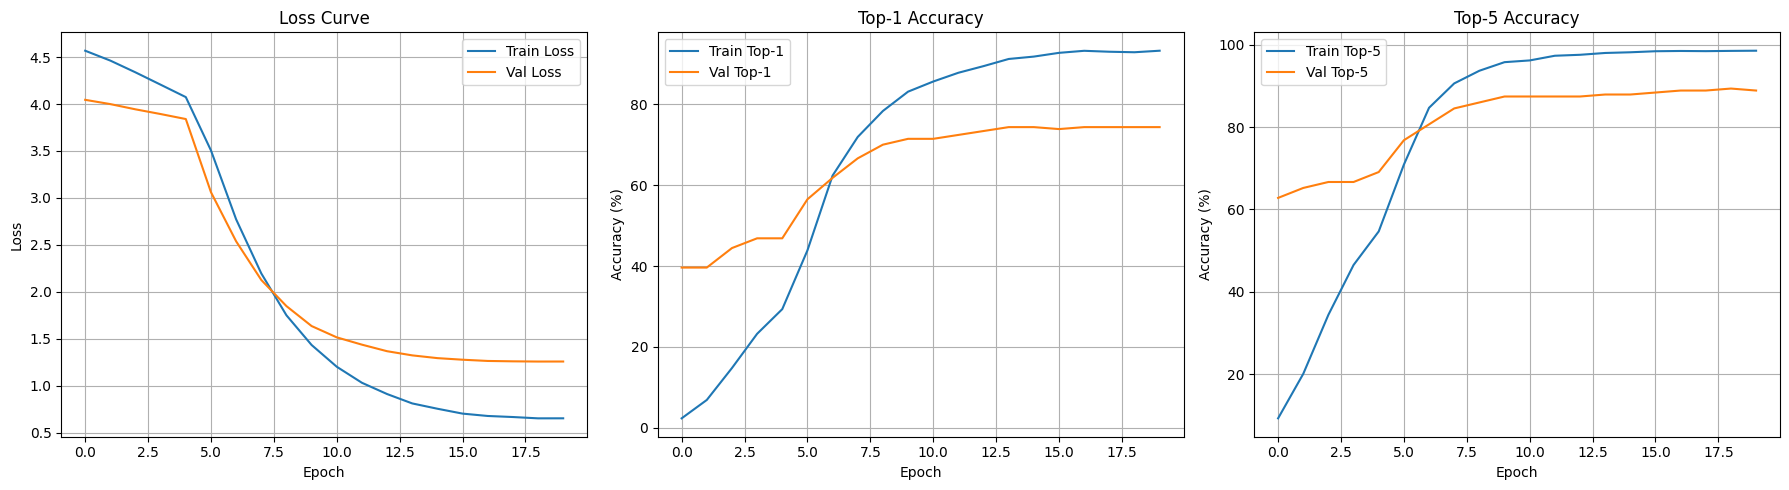

In [ ]:
train_model(model, train_loader, val_loader, EPOCHS, LR)

# **Testing**

In [ ]:
import timm
import argparse
import torch

# Allow argparse.Namespace inside checkpoint
torch.serialization.add_safe_globals([argparse.Namespace])

# Create the EXACT model architecture used for training
backbone = timm.create_model(
    "vit_base_patch14_reg4_dinov2.lvd142m",
    pretrained=False,
    num_classes=0  # remove original classifier
)

# Re-instantiate the DINOv2Model
FEATURE_DIM = 768   # vit-base hidden size
HIDDEN_DIM = 1024   # your classifier size
model = DINOv2Model(backbone, FEATURE_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

ckpt = torch.load(f"{SAVE_DIR}/best_optimized.pth", map_location=DEVICE)

model.load_state_dict(ckpt["model"])
prototypes = ckpt["prototypes"].to(DEVICE)

model.eval()

DINOv2Model(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
        

In [ ]:
paired_species = []
with open(f"{DATA_ROOT}/list/class_with_pairs.txt") as f:
    for line in f:
        orig = int(line.strip())
        paired_species.append(ID2IDX[orig])

unpaired_species = []
with open(f"{DATA_ROOT}/list/class_without_pairs.txt") as f:
    for line in f:
        orig = int(line.strip())
        unpaired_species.append(ID2IDX[orig])

print("Paired:", len(paired_species), "Unpaired:", len(unpaired_species))

Paired: 60 Unpaired: 40


In [ ]:
test_ds = TestDataset(val_items, TEST_ROOT, val_transform)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

In [ ]:
def topk_accuracy(logits, labels, topk=(1,5)):
    maxk = max(topk)
    batch_size = labels.size(0)

    _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
    pred = pred.t()

    correct = pred.eq(labels.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0).item()
        acc = (correct_k / batch_size) * 100
        res.append(acc)

    return res[0], res[1]   # ALWAYS return Top-1 and Top-5


In [ ]:
@torch.no_grad()
def test_model(model, loader, prototypes, alpha=1.0):
    model.eval()

    # ===========================
    # Overall stats
    # ===========================
    total = 0
    top1_correct = 0
    top5_correct = 0

    # ===========================
    # Paired stats
    # ===========================
    paired_total = 0
    paired_top1 = 0
    paired_top5 = 0

    # ===========================
    # Unpaired stats
    # ===========================
    unpaired_total = 0
    unpaired_top1 = 0
    unpaired_top5 = 0

    pn = F.normalize(prototypes.to(DEVICE), dim=1)

    for x, y in tqdm(loader, desc="Testing"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits, feat, _ = model(x, return_feat=True)

        # Prototype fusion
        fn = F.normalize(feat, dim=1)
        proto_logits = (fn @ pn.t()) * 10
        fused = logits + alpha * proto_logits

        # -------- Overall accuracy --------
        a1, a5 = topk_accuracy(fused, y)
        bs = y.size(0)

        top1_correct += a1 * bs / 100
        top5_correct += a5 * bs / 100
        total += bs

        # -------- Paired/Unpaired --------
        preds = fused.argmax(dim=1).tolist()
        labs  = y.tolist()

        for i, (lab, pred) in enumerate(zip(labs, preds)):

            # ---------- PAIRED ----------
            if lab in paired_species:
                paired_total += 1

                if pred == lab:
                    paired_top1 += 1

                top5_labels = torch.topk(fused[i], 5).indices.tolist()
                if lab in top5_labels:
                    paired_top5 += 1

            # ---------- UNPAIRED ----------
            else:
                unpaired_total += 1

                if pred == lab:
                    unpaired_top1 += 1

                top5_labels = torch.topk(fused[i], 5).indices.tolist()
                if lab in top5_labels:
                    unpaired_top5 += 1


    # ===========================
    # Compute final metrics
    # ===========================
    results = {
        "overall_top1": (top1_correct / total) * 100,
        "overall_top5": (top5_correct / total) * 100,

        "paired_top1": (paired_top1 / paired_total) * 100 if paired_total > 0 else 0,
        "paired_top5": (paired_top5 / paired_total) * 100 if paired_total > 0 else 0,

        "unpaired_top1": (unpaired_top1 / unpaired_total) * 100 if unpaired_total > 0 else 0,
        "unpaired_top5": (unpaired_top5 / unpaired_total) * 100 if unpaired_total > 0 else 0,
    }

    # Pretty print
    print("\n====== FINAL TEST RESULTS ======")
    print(f"Overall Top-1:     {results['overall_top1']:.2f}%")
    print(f"Overall Top-5:     {results['overall_top5']:.2f}%")
    print("------------------------------------")
    print(f"Paired Top-1:      {results['paired_top1']:.2f}%")
    print(f"Paired Top-5:      {results['paired_top5']:.2f}%")
    print("------------------------------------")
    print(f"Unpaired Top-1:    {results['unpaired_top1']:.2f}%")
    print(f"Unpaired Top-5:    {results['unpaired_top5']:.2f}%")
    print("====================================\n")

    return results

In [ ]:
result = test_model(model, test_loader, prototypes, ALPHA)

Testing: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


====== FINAL TEST RESULTS ======
Overall Top-1:     74.40%
Overall Top-5:     87.92%
------------------------------------
Paired Top-1:      90.20%
Paired Top-5:      98.69%
------------------------------------
Unpaired Top-1:    29.63%
Unpaired Top-5:    57.41%

